# Hyperparameter Tuning

## Goal

The goal of this experiment is to find the best combination of hyperparameters across a range of different regressor models and select the best model.

## Experiment

We conduct the experiment with following decisions:

- A time window of 1 year is used per study area, covering each year of recording.
- We use the dataset created in the previous experiment.
- We perform hyperparameter tuning for the following classifiers:
  - Extreme Learning Machine
  - K-Nearest Neighbors
  - Linear Regression fitted with Stochastic Gradient Descent
  - Support Vector Machine
  - Extra Trees
  - Histogram-based Gradient Boosting
  - Random Forest
  - eXtreme Gradient Boosting
- Bayesian Optimization with Optuna is used to find the best hyperparameters, using F1 score with stratified 5-fold cross-validation per iteration as the objective.
- The number of trials is set to 100 for models.

We load the dataset and perform the hyperparameter tuning for each model:

In [1]:
# Define the metric and load the data
import pandas as pd
from sklearn.metrics import f1_score, make_scorer

# Define the metric
f1_scorer = make_scorer(f1_score)

# Load the data
data = pd.read_csv("../data/processed/compositing/data.csv")
target = pd.read_csv("../data/processed/compositing/target.csv")["0"]

In [2]:
# Create save folder and wrapper functions
from pathlib import Path
from typing import Any

save_folder = "../models/"
Path(save_folder).mkdir(parents=True, exist_ok=True)


def _suggest_categorical(*args: Any, **kwargs: Any) -> tuple:  # noqa: ANN401
    return "suggest_categorical", args, kwargs


def _suggest_discrete_uniform(*args: Any, **kwargs: Any) -> tuple:  # noqa: ANN401
    return "suggest_discrete_uniform", args, kwargs


def _suggest_float(*args: Any, **kwargs: Any) -> tuple:  # noqa: ANN401
    return "suggest_float", args, kwargs


def _suggest_int(*args: Any, **kwargs: Any) -> tuple:  # noqa: ANN401
    return "suggest_int", args, kwargs

In [3]:
# Extreme Learning Machine
from logging import INFO
from sys import stdout

from loguru import logger
from skelm import ELMClassifier

from slc.models import hyperparam_search

logger.configure(handlers=[{"sink": stdout, "format": "{message}", "level": INFO}])

elm_model = ELMClassifier(random_state=42)
search_space = [
    _suggest_float("alpha", 1e-8, 1e5, log=True),
    _suggest_categorical("include_original_features", [True, False]),
    _suggest_categorical("ufunc", ["tanh", "sigm", "relu", "lin"]),
    _suggest_categorical("n_neurons", [1, None]),
    _suggest_float("density", 0.01, 0.99),
]

elm_pipe, elm_study = hyperparam_search(
    elm_model,
    search_space,
    data,
    target,
    f1_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

elm_pipe

Files already exist, skipping search: ../models/ELMClassifier_study.pkl, ../models/ELMClassifier.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=49)),
                ('model',
                 ELMClassifier(alpha=1.2812134573270824e-07,
                               density=0.6776376082222717, random_state=42,
                               ufunc='relu'))])

In [4]:
# K-Nearest Neighbour
from sklearn.neighbors import KNeighborsClassifier

from slc.models import hyperparam_search

knn_model = KNeighborsClassifier(n_jobs=-1)
search_space = [
    _suggest_int("n_neighbors", 1, 100),
    _suggest_categorical("weights", ["uniform", "distance"]),
    _suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
]

knn_pipe, knn_study = hyperparam_search(
    knn_model,
    search_space,
    data,
    target,
    f1_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

knn_pipe

Files already exist, skipping search: ../models/KNeighborsClassifier_study.pkl, ../models/KNeighborsClassifier.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=156)),
                ('model',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=22,
                                      weights='distance'))])

In [5]:
# Linear Regression
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(random_state=42)
search_space = [
    _suggest_categorical(
        "loss",
        [
            "squared_epsilon_insensitive",
            "modified_huber",
            "log_loss",
            "perceptron",
            "squared_error",
            "squared_hinge",
            "epsilon_insensitive",
            "huber",
            "hinge",
        ],
    ),
    _suggest_float("alpha", 1e-6, 1e5, log=True),
    _suggest_float("l1_ratio", 0, 1),
    _suggest_int("max_iter", 1, 10000),
]

sgd_pipe, sgd_study = hyperparam_search(
    sgd_model,
    search_space,
    data,
    target,
    f1_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

sgd_pipe

Files already exist, skipping search: ../models/SGDClassifier_study.pkl, ../models/SGDClassifier.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model',
                 SGDClassifier(alpha=3.55930270431274e-06,
                               l1_ratio=0.286997536867199, loss='perceptron',
                               max_iter=4037, random_state=42))])

In [6]:
# Support Vector Machine
from sklearn.svm import SVC

svm_model = SVC()
search_space = [
    _suggest_float("C", 1e-5, 1e5, log=True),
    _suggest_categorical("kernel", ["poly", "rbf", "sigmoid"]),
]

svm_pipe, svm_study = hyperparam_search(
    svm_model,
    search_space,
    data,
    target,
    f1_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
    always_standardize=True,
)

svm_pipe

Files already exist, skipping search: ../models/SVC_study.pkl, ../models/SVC.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model', SVC(C=1.3287001143730814))])

In [7]:
# Extra Trees
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_jobs=-1, random_state=42)
search_space = [
    _suggest_int("n_estimators", 1, 200),
    _suggest_float("min_impurity_decrease", 1e-5, 0.5, log=True),
    _suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
]

et_pipe, et_study = hyperparam_search(
    et_model,
    search_space,
    data,
    target,
    f1_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

et_pipe

Files already exist, skipping search: ../models/ExtraTreesClassifier_study.pkl, ../models/ExtraTreesClassifier.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesClassifier(criterion='entropy',
                                      min_impurity_decrease=0.0003656228731496513,
                                      n_estimators=126, n_jobs=-1,
                                      random_state=42))])

In [8]:
# Histogram-based Gradient Boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_model = HistGradientBoostingClassifier(random_state=42)
search_space = [
    _suggest_int("max_iter", 10, 1000),
    _suggest_float("learning_rate", 0.001, 0.5, log=True),
    _suggest_int("max_leaf_nodes", 2, 1000),
    _suggest_categorical("l2_regularization", [0, 1e-10, 1e-5, 1e-3, 1e-1, 1]),
]

hgb_pipe, hgb_study = hyperparam_search(
    hgb_model,
    search_space,
    data,
    target,
    f1_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

hgb_pipe

Files already exist, skipping search: ../models/HistGradientBoostingClassifier_study.pkl, ../models/HistGradientBoostingClassifier.pkl


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 HistGradientBoostingClassifier(l2_regularization=1,
                                                learning_rate=0.2577887030996282,
                                                max_iter=154, max_leaf_nodes=78,
                                                random_state=42))])

In [9]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
search_space = [
    _suggest_int("n_estimators", 1, 200),
    _suggest_int("max_depth", 1, 1000),
    _suggest_float("max_features", 0.1, 1.0),
    _suggest_float("min_samples_split", 1e-5, 0.5, log=True),
    _suggest_float("min_samples_leaf", 1e-5, 0.5, log=True),
    _suggest_categorical("bootstrap", [True, False]),
    _suggest_categorical(
        "criterion",
        ["gini", "entropy", "log_loss"],
    ),
]

rf_pipe, rf_study = hyperparam_search(
    rf_model,
    search_space,
    data,
    target,
    f1_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

rf_pipe

Files already exist, skipping search: ../models/RandomForestClassifier_study.pkl, ../models/RandomForestClassifier.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=172)),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=891,
                                        max_features=0.6049782259187579,
                                        min_samples_leaf=1.4580933911423414e-05,
                                        min_samples_split=0.15274064666951756,
                                        n_estimators=173, n_jobs=-1,
                                        random_state=42))])

In [10]:
# eXtreme Gradient Boosting
from xgboost import XGBClassifier

from slc.models import hyperparam_search

xgb_model = XGBClassifier(n_jobs=-1, random_state=42)
search_space = [
    _suggest_int("n_estimators", 10, 200),
    _suggest_int("max_depth", 1, 20),
    _suggest_float("learning_rate", 0.001, 0.5, log=True),
    _suggest_float("gamma", 0, 0.5),
    _suggest_int("min_child_weight", 1, 11),
    _suggest_int("reg_alpha", 40, 180),
    _suggest_float("reg_lambda", 0, 1),
    _suggest_float("colsample_bytree", 0.5, 1),
]

xgb_pipe, xgb_study = hyperparam_search(
    xgb_model,
    search_space,
    data,
    target,
    f1_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

xgb_pipe

Files already exist, skipping search: ../models/XGBClassifier_study.pkl, ../models/XGBClassifier.pkl


/Users/peterhofinger/miniforge3/envs/slc/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [21:33:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6267280712530368, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.15008478561153937,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.49383803830282824, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=8, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=72, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

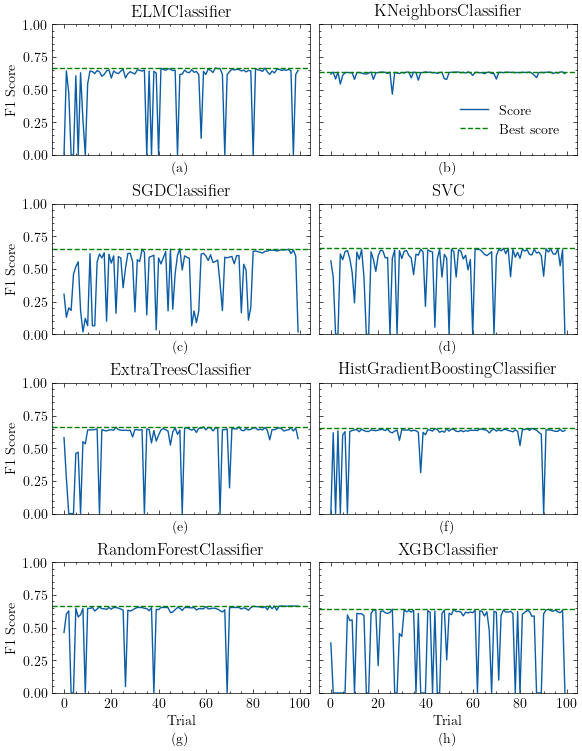

In [11]:
# Plot the hyperparam search scores during search
import matplotlib.pyplot as plt
import scienceplots  # noqa: F401

from slc.visualize import label_subplots, save_fig

plt.style.use("science")

studies = [
    elm_study,
    knn_study,
    sgd_study,
    svm_study,
    et_study,
    hgb_study,
    rf_study,
    xgb_study,
]

fig, axs = plt.subplots(4, 2, figsize=(5.81, 7.5), constrained_layout=True)

for i, ax, study in zip(range(len(studies)), axs.flat, studies, strict=False):
    trials = study.trials_dataframe()
    ax.plot(trials["value"], label="Score")
    ax.set_title(study.study_name)
    if i in [6, 7]:
        ax.set_xlabel("Trial")
    else:
        ax.set_xticklabels([])
    if i in [0, 2, 4, 6]:
        ax.set_ylabel("F1 Score")
    else:
        ax.set_yticklabels([])
    ax.axhline(study.best_value, color="g", linestyle="--", label="Best score")
    ax.set_ylim(0, 1)
    if i == 1:
        ax.legend(loc="lower left", bbox_to_anchor=(0.5, 0.05))

label_subplots(axs.flat, y_offset=[0.05] * 6 + [0.3] * 2)

save_fig(fig, "../reports/figures/hyperparameter_tuning/Hyperparameter Tuning.pdf")

In above figure you can see the hyperparameter tuning process for each model. The best F1 Score of each model lies between 0.6 and 0.7, while the F1 Scores during the tuning processes vary greatly. For example the K-Nearest Neighbors classifier produces only F1 Scores above 0.5 and the eXtreme Gradient Boosting classifier frequently approaches and even reaches F1 Scores of 0. We compute the F1 Score, Accuracy and Kappa for each model:

In [12]:
# Evaluate the tuned models
from collections import defaultdict

import pandas as pd
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from tqdm.notebook import tqdm

csv_path = "../reports/hyperparameter_tuning.csv"
scoring = {
    "F1 Score": make_scorer(f1_score),
    "Accuracy": make_scorer(accuracy_score),
    "Kappa": make_scorer(cohen_kappa_score),
}

tuned_models = [
    elm_pipe,
    knn_pipe,
    sgd_pipe,
    svm_pipe,
    rf_pipe,
    et_pipe,
    hgb_pipe,
    xgb_pipe,
]

if not Path(csv_path).exists():
    # Create columns
    model_names = [model.steps[-1][1].__class__.__name__ for model in tuned_models]
    columns = defaultdict(list)
    columns["Model"] = model_names

    # Cross validate default and tuned models
    for model in tqdm(tuned_models):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_result = cross_validate(
            model, data, target, cv=cv, scoring=scoring, n_jobs=-1
        )

        for metric in scoring:
            columns[metric].append(cv_result[f"test_{metric}"].mean())

    # Create dataframe
    results = pd.DataFrame(columns)
    results = results.set_index("Model")
    results.to_csv(csv_path)
else:
    results = pd.read_csv(csv_path, index_col="Model")

results

,F1 Score,Accuracy,Kappa
Model,,,
ELMClassifier,0.665217,0.945032,0.635514
KNeighborsClassifier,0.635228,0.942792,0.604808
SGDClassifier,0.653632,0.929966,0.615464
SVC,0.657140,0.944421,0.627253
RandomForestClassifier,0.665734,0.937092,0.631180
ExtraTreesClassifier,0.663893,0.945235,0.634358
HistGradientBoostingClassifier,0.651440,0.943607,0.621136
XGBClassifier,0.640827,0.942384,0.609974
